In [2484]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2485]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [2486]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [2487]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [2488]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [2489]:
data = data[data['FIPS'] != 'not county']

In [2490]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [2491]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [2492]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [2493]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str, 'Urban_Influence_Code_2013': str})

*Note: The urban influence code is not a smooth scale from 1 = most urban to 12 = least urban. It includes several categories of county — metropolitan, suburban, rural — and then ranks within each category. So it must be treted as categorical.*

In [2494]:
population.columns = ['FIPS', 'urban_inf', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [2495]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [2496]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])

In [2497]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [2498]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,0.033898
5,01007,1,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [2499]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [2500]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,-0.033898
5,01007,1,22533,-0.016670,0.102094


In [2501]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [2502]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
unemployment = unemployment.set_index('FIPS')
unemployment2 = pd.read_excel('data/CLF01.xls', sheetname='Sheet9', usecols=['STCOU', 'CLF040210D'], converters={'STCOU': str})
unemployment2.columns = ['FIPS', 'unemployment_2009']
unemployment = unemployment.join(unemployment2.set_index('FIPS'))
unemployment['unemp_change'] = unemployment['unemployment_2009'] - unemployment['unemployment']
data = data.join(unemployment.drop('unemployment_2009', axis=1))

The features are the unemployment rate in 2014 and the change in that rate from 2009.

In [2503]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
poverty = poverty.set_index('FIPS')
poverty2 = pd.read_excel('data/IPE01.xls', sheetname='Sheet5', usecols=['STCOU', 'IPE120209D'], converters={'STCOU': str})
poverty2.columns = ['FIPS', 'poverty_2009']
poverty = poverty.join(poverty2.set_index('FIPS'))
poverty['pov_change'] = poverty['poverty_2009'] - poverty['poverty']
data = data.join(poverty.drop('poverty_2009', axis=1))

Similarly, the poverty rate in 2014 and the change from 2009.

In [2504]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [2505]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [2506]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [2507]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [2508]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [2509]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [2510]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [2511]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [2512]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [2513]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [2514]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [2515]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [2516]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [2517]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [2518]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [2519]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [2520]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [2521]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [2522]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [2523]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [2524]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [2525]:
data.isnull().sum()

state             0
name              0
< diploma        10
degree+          10
urban_inf        10
pop_2014         10
pop_inc          10
foreign_inc      13
unemployment     11
unemp_change     13
poverty          13
median_hh_inc    13
pov_change       13
median_age        9
hh_afr_am        11
hh_hisp          11
hh_female        11
hh_food_st       11
foreign_07        9
vets             11
vets_male         9
viol_crime       18
prop_crime       18
dtype: int64

In [2526]:
len(data.dropna())

3130

In [2527]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [2528]:
data = data.dropna()

In [2529]:
(data == 0).sum()

state              0
name               0
< diploma          0
degree+            0
urban_inf          0
pop_2014           0
pop_inc            0
foreign_inc      156
unemployment       0
unemp_change      11
poverty            0
median_hh_inc      0
pov_change        61
median_age         0
hh_afr_am         85
hh_hisp            4
hh_female          2
hh_food_st         3
foreign_07        33
vets               0
vets_male          0
viol_crime       163
prop_crime       100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [2530]:
data.describe()

,< diploma,degree+,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,poverty,median_hh_inc,pov_change,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,1.017577e+05,0.002831,0.395946,6.235559,2.946709,16.837380,47121.392971,-0.539904,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.263767e+05,0.041968,3.043823,2.256287,1.807379,6.422444,12099.573945,2.161624,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,8.900000e+01,-0.177510,-6.333333,1.200000,-8.200000,3.200000,21658.000000,-15.900000,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,1.102950e+04,-0.021689,0.007641,4.600000,1.700000,12.100000,38889.000000,-1.700000,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,2.574250e+04,-0.004227,0.057769,6.000000,2.800000,15.800000,45227.500000,-0.500000,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,6.785250e+04,0.020261,0.200482,7.500000,4.000000,20.400000,52529.750000,0.700000,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,1.007270e+07,0.727044,119.000000,24.000000,13.600000,47.400000,125635.000000,17.400000,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


From the stats, the dataset certainly contains strong outliers that will need to be dealt with.

In [2531]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [2532]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [2533]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [2534]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [2535]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [2536]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [2537]:
data = data.join(targets.set_index('FIPS')) # drop na

In [2538]:
data.isnull().sum()

state            0
name             0
< diploma        0
degree+          0
urban_inf        0
pop_2014         0
pop_inc          0
foreign_inc      0
unemployment     0
unemp_change     0
poverty          0
median_hh_inc    0
pov_change       0
median_age       0
hh_afr_am        0
hh_hisp          0
hh_female        0
hh_food_st       0
foreign_07       0
vets             0
vets_male        0
viol_crime       0
prop_crime       0
death_rate       4
numeric          4
dtype: int64

In [2539]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_inf,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1,479488.0,0.085790,0.054824,5.7,4.5,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1,61706.0,0.104081,0.045556,4.2,3.7,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1,558519.0,0.044853,0.059893,4.6,4.0,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2,275584.0,0.090019,0.018015,4.5,5.7,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [2540]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [2541]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [2542]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [2543]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


Look at overall distribution of targets.

In [2544]:
counts = pd.DataFrame(data_31.groupby(['state', 'numeric']).size())
counts.head()

0
state numeric   
AK    1.0      1
      5.0      1
      7.0      2
      11.0     2
      13.0     2

In [2545]:
counts = counts.reset_index()
counts.columns = ['state', 'numeric', 'count']
counts['total'] = maybe.apply(lambda row: counties_by_state.loc[row['state'], 'total'], axis=1)
counts['percent'] = counts['count'] / counts['total']
states = sorted(counts['state'].unique())

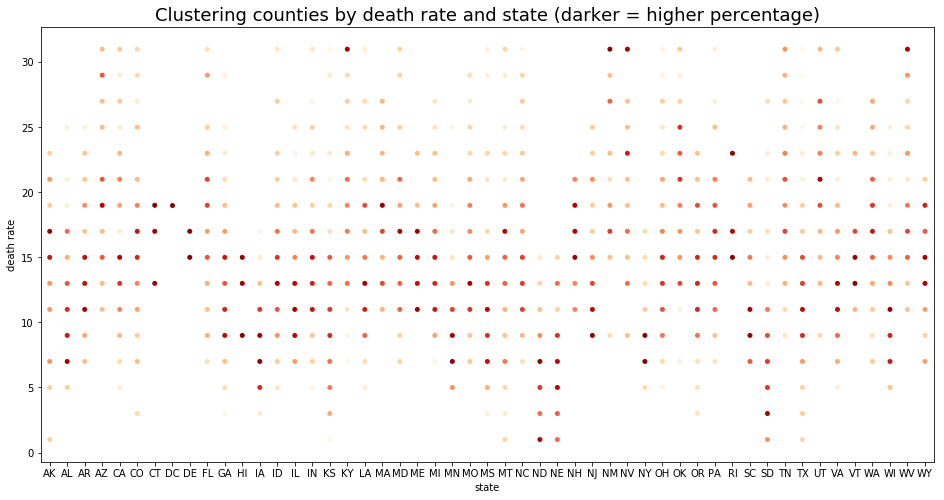

In [2775]:
plt.rcParams["figure.figsize"] = [16.0, 8.0]
ax = sns.stripplot(data=counts, x='state', y='numeric', hue='percent', palette='OrRd')
ax.legend_.remove()
ax.set_title('Clustering counties by death rate and state (darker = higher percentage)', size=18)
ax.set_ylabel('death rate')
ax.figure.savefig('images/county_rates.png')

While there are some states with outlying concentrations of counties with low or high death rates, the distribution is fairly even overall.

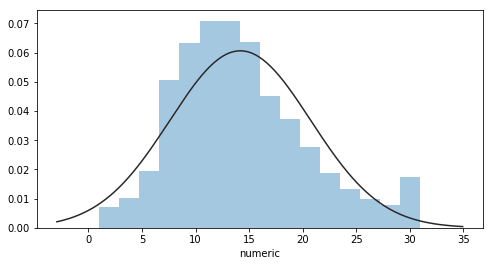

In [2776]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = [8.0, 4.0]
target_hist = sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)
target_hist.figure.savefig('images/target_hist.png')

The target distribution is not normal, but it follows the general shape of a normal curve except for the high-end spike at death_rate = 31. The distribution of those outlier targets is highly uneven and potentially problematic, so they might need to be removed later to improve accuracy. The class imbalance will have to be dealt with in the modeling. Some columns also are no longer needed, but keep them as raw data. 

In [2548]:
target_outliers = list(target_outliers.index)

data_raw = data.copy()
data = data.drop(['state', 'name', 'pop_2014'], axis=1)

In [2549]:
bivariate = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.596235  0.185915     0.017175      0.444894   
degree+         0.596235  1.000000  0.437384     0.040137      0.344505   
pop_inc         0.185915  0.437384  1.000000     0.003214      0.265479   
foreign_inc     0.017175  0.040137  0.003214     1.000000      0.006487   
unemployment    0.444894  0.344505  0.265479     0.006487      1.000000   
unemp_change    0.099960  0.104568  0.019885     0.001546      0.183943   
poverty         0.676247  0.454771  0.279422     0.016851      0.615135   
median_hh_inc   0.555187  0.682043  0.471092     0.020453      0.472713   
pov_change      0.026931  0.041624  0.043384     0.000316      0.183201   
median_age      0.207144  0.180067  0.366550     0.037000      0.045748   
hh_afr_am       0.337359  0.078255  0.089242     0.001260      0.393471   
hh_hisp         0.416976  0.014507  0.157683     0.001310      0.007594   
hh_female       0.535661 

**poverty** correlates strongly with several other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [2550]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

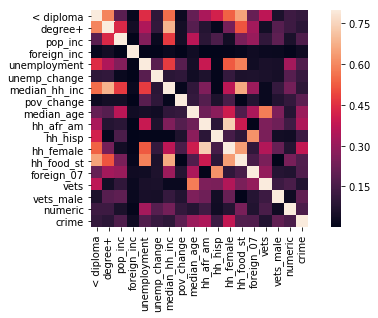

In [2777]:
corrmat = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
heatmap = sns.heatmap(corrmat, vmax=.8, square=True)
heatmap.figure.savefig('images/heatmap.png')

There are other correlations, but varaince inflation factor (VIF) analysis will be used to determine which should be removed. But first look at outliers in the independent variables.

In [2552]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [2553]:
outliers = get_outliers(data.drop(['urban_inf', 'death_rate'], axis=1))
len(data[outliers.any(axis=1)])

1547

In [2554]:
extreme_outliers = get_outliers(data.drop(['urban_inf', 'death_rate'], axis=1), 2.5)
len(data[extreme_outliers.any(axis=1)])

927

In [2555]:
xx_outliers = list((data[extreme_outliers.sum(axis=1) > 1]).index)
len(xx_outliers)

273

Almost half the dataset contains outliers, and more than a quarter contains extreme outliers that are more than 2.5 times the IQR below the first quartile or above the third. As an alternative to dropping a large number of samples, apply robust scaling to the predictors. Scikit-learn has two solutions, robust scaling and quantile transformation. Try them both. If necessary drop the most extreme (xx) outliers, those samples having more than one extreme outlier.

In [2556]:
from sklearn.model_selection import train_test_split

data_train, data_test, targets_train, targets_test = train_test_split(data.drop('death_rate', axis=1),
                                                                     data['death_rate'], test_size=.35,
                                                                     stratify=data['death_rate'], random_state=13)

It is necessary to separate the training and test data before scaling/transforming to prevent data leakage from the test data when fitting the scaling and transformation algorithms. 

In [2557]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer
robust = RobustScaler()
quantile = QuantileTransformer()

r_train = pd.DataFrame(robust.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
r_train['urban_inf'] = data_train['urban_inf']

q_train = pd.DataFrame(quantile.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
q_train['urban_inf'] = data_train['urban_inf']

*Note: Both robust scaling and quantile transformation leave binary features unchanged, so __urban_inf__ will be one-hot encoded later.*

Use VIF analysis to programmatically eliminate the variables with the highest VIF scores.

In [2558]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
remove = ['urban_inf', 'numeric']
features = r_train.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,4.692216,< diploma
1,3.354605,degree+
2,1.654689,pop_inc
3,1.007878,foreign_inc
4,2.001452,unemployment
5,1.083473,unemp_change
6,3.000470,median_hh_inc
7,1.137715,pov_change
8,2.291184,median_age
9,2.692483,hh_afr_am


In [2559]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = r_train.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
    
r_features = list(features.columns) + ['urban_inf']
vif

,VIF,features
0,1.446837,degree+
1,1.387094,pop_inc
2,1.006156,foreign_inc
3,1.469169,unemployment
4,1.062661,unemp_change
5,1.088208,pov_change
6,1.467785,hh_afr_am
7,1.117673,hh_hisp
8,1.162081,vets
9,1.227921,vets_male


In [2560]:
vif2 = pd.DataFrame()
remove = ['urban_inf', 'numeric']
features2 = q_train.drop(remove, axis=1)
vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
vif2["features"] = features2.columns
vif2

,VIF,features
0,14.137382,< diploma
1,11.976201,degree+
2,7.264671,pop_inc
3,5.406005,foreign_inc
4,8.466852,unemployment
5,4.521266,unemp_change
6,9.859576,median_hh_inc
7,4.345796,pov_change
8,9.687228,median_age
9,9.356449,hh_afr_am


In [2561]:
max_VIF = max(vif2['VIF'])
while len(vif2) > 11:
    remove = remove + list(vif2[vif2['VIF'] == max_VIF]['features'])
    features2 = q_train.drop(remove, axis=1)
    vif2 = pd.DataFrame()
    vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
    vif2["features"] = features2.columns
    max_VIF = max(vif2['VIF'])

q_features = list(features2.columns) + ['urban_inf']   
vif2

,VIF,features
0,6.111847,degree+
1,5.871037,pop_inc
2,5.083158,foreign_inc
3,5.500962,unemployment
4,4.292346,unemp_change
5,3.523762,pov_change
6,6.141467,hh_afr_am
7,5.468528,hh_hisp
8,3.810442,vets
9,3.579920,vets_male


Although the VIF scores were higher with the quantile-transformed data, the order was the same, so proceed with the 11 features from the scaled data that scored below 2.

Try a range of classifiers. 

In [2562]:
Xr1_train = r_train.loc[:, r_features]
Xr1_train = pd.get_dummies(Xr1_train, prefix='urb_inf_', columns=['urban_inf'])
Yr1_train = targets_train

Xq1_train = q_train.loc[:, r_features]
Xq1_train = pd.get_dummies(Xq1_train, prefix='urb_inf_', columns=['urban_inf'])
Yq1_train = targets_train

In [2563]:
from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [2564]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2565]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(class_weight='balanced', tol=1e-3)
rfc = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

In [2566]:
classifiers = [lrc, gbc, sgd, rfc, svc, knn]
names = ['lrc', 'gbc', 'sgd', 'rfc', 'svc', 'knn']
full_names = {'lrc':'Logistic regression', 'gbc':'Gradient boosting', 'sgd':'Stochastic gradient descent',
              'rfc':'Random forest', 'svc':'Support vector', 'knn':'K-Nearest neighbors'}

index = pd.MultiIndex.from_product([['Y16', 'Y8', 'Y4', 'Y2'], ['r', 'q'], [1, 2]])
results = pd.DataFrame(index=index, columns=names)

def run_trials(X, Y, targets, scale, feature_set):
    for name, clf in zip(names, classifiers):
        scores = cross_val_score(clf, X, Y, scoring=matthews)
        results.loc[targets, scale, feature_set][name] = np.mean(scores)
        %time print('{} scores: {}'.format(full_names[name], scores))

In [2567]:
run_trials(Xr1_train, Yr1_train, 'Y16', 'r', 1)

Logistic regression scores: [ 0.07224075  0.08373754  0.06169728]
CPU times: user 2.07 ms, sys: 135 µs, total: 2.21 ms
Wall time: 543 µs
Gradient boosting scores: [ 0.06564323  0.05347125  0.05369751]
CPU times: user 365 µs, sys: 54 µs, total: 419 µs
Wall time: 403 µs
Stochastic gradient descent scores: [ 0.03590956  0.04562381  0.01788978]
CPU times: user 1.49 ms, sys: 79 µs, total: 1.57 ms
Wall time: 391 µs
Random forest scores: [ 0.05606924  0.03888256  0.02337687]
CPU times: user 349 µs, sys: 53 µs, total: 402 µs
Wall time: 382 µs
Support vector scores: [ 0.06494332  0.08073868  0.06422116]
CPU times: user 349 µs, sys: 60 µs, total: 409 µs
Wall time: 386 µs
K-Nearest neighbors scores: [ 0.05116946  0.06057621  0.07395291]
CPU times: user 353 µs, sys: 34 µs, total: 387 µs
Wall time: 392 µs


All of the stock classifiers performed poorly, with support vector doing the best, followed by gradient boosting and logistic regression.

In [2568]:
run_trials(Xq1_train, Yq1_train, 'Y16', 'q', 1)

Logistic regression scores: [ 0.05517806  0.07216968  0.05162715]
CPU times: user 1.65 ms, sys: 170 µs, total: 1.82 ms
Wall time: 468 µs
Gradient boosting scores: [ 0.06920408  0.07383779  0.03745276]
CPU times: user 359 µs, sys: 49 µs, total: 408 µs
Wall time: 390 µs
Stochastic gradient descent scores: [ 0.05583725  0.04144789  0.04682596]
CPU times: user 1.96 ms, sys: 154 µs, total: 2.11 ms
Wall time: 524 µs
Random forest scores: [ 0.04280496  0.02932204  0.06575737]
CPU times: user 400 µs, sys: 64 µs, total: 464 µs
Wall time: 443 µs
Support vector scores: [ 0.06257489  0.06058553  0.04800599]
CPU times: user 377 µs, sys: 56 µs, total: 433 µs
Wall time: 411 µs
K-Nearest neighbors scores: [ 0.04721797  0.0680261   0.04863588]
CPU times: user 382 µs, sys: 44 µs, total: 426 µs
Wall time: 418 µs


The quantile-transformed data performed even worse. Try an alternative selection process starting with correlations with the target variable.

In [2569]:
bivariate = r_train.drop('urban_inf', axis=1).corr().abs()
bivariate.loc['numeric'].drop('numeric')

< diploma        0.129658
degree+          0.128835
pop_inc          0.065526
foreign_inc      0.023970
unemployment     0.333562
unemp_change     0.196317
median_hh_inc    0.249051
pov_change       0.098258
median_age       0.078755
hh_afr_am        0.138155
hh_hisp          0.050569
hh_female        0.077553
hh_food_st       0.256955
foreign_07       0.090891
vets             0.127107
vets_male        0.042540
crime            0.146001
Name: numeric, dtype: float64

In [2570]:
features2 = list(bivariate[bivariate.loc['numeric'] > .05].drop('numeric').index)

In [2571]:
vif = pd.DataFrame()
features = r_train.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,4.691511,< diploma
1,3.338118,degree+
2,1.653951,pop_inc
3,2.001330,unemployment
4,1.081916,unemp_change
5,2.994200,median_hh_inc
6,1.137668,pov_change
7,2.090084,median_age
8,2.640925,hh_afr_am
9,2.495835,hh_hisp


In [2572]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = r_train.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,1.426356,degree+
1,1.508867,pop_inc
2,1.471894,unemployment
3,1.063805,unemp_change
4,1.107732,pov_change
5,1.914992,median_age
6,1.393385,hh_afr_am
7,1.125245,hh_hisp
8,1.572265,vets
9,1.331433,crime


In [2573]:
features2 = list(vif['features']) + ['urban_inf']
Xr2_train = r_train.loc[:, features2]
Xr2_train = pd.get_dummies(Xr2_train, prefix='urb_inf_', columns=['urban_inf'])
Yr2_train = targets_train

Xq2_train = q_train.loc[:, (features2)]
Xq2_train = pd.get_dummies(Xq2_train, prefix='urb_inf_', columns=['urban_inf'])
Yq2_train = targets_train

In [2574]:
run_trials(Xr2_train, Yr2_train, 'Y16', 'r', 2)

Logistic regression scores: [ 0.07667987  0.07249636  0.06591796]
CPU times: user 1.57 ms, sys: 96 µs, total: 1.66 ms
Wall time: 411 µs
Gradient boosting scores: [ 0.06567434  0.05806323  0.06043003]
CPU times: user 638 µs, sys: 133 µs, total: 771 µs
Wall time: 711 µs
Stochastic gradient descent scores: [ 0.02115983  0.05902871  0.01200934]
CPU times: user 1.56 ms, sys: 86 µs, total: 1.65 ms
Wall time: 414 µs
Random forest scores: [ 0.07040401  0.06335578  0.07735963]
CPU times: user 391 µs, sys: 55 µs, total: 446 µs
Wall time: 433 µs
Support vector scores: [ 0.06517486  0.09615877  0.07827571]
CPU times: user 359 µs, sys: 52 µs, total: 411 µs
Wall time: 395 µs
K-Nearest neighbors scores: [ 0.04180767  0.03719968  0.06801806]
CPU times: user 422 µs, sys: 47 µs, total: 469 µs
Wall time: 460 µs


In [2575]:
run_trials(Xq2_train, Yq2_train, 'Y16', 'q', 2)

Logistic regression scores: [ 0.05231624  0.06853905  0.05504075]
CPU times: user 1.5 ms, sys: 86 µs, total: 1.59 ms
Wall time: 396 µs
Gradient boosting scores: [ 0.07578598  0.06738574  0.06573165]
CPU times: user 353 µs, sys: 62 µs, total: 415 µs
Wall time: 391 µs
Stochastic gradient descent scores: [ 0.04445081  0.05293809  0.02522092]
CPU times: user 1.56 ms, sys: 87 µs, total: 1.65 ms
Wall time: 412 µs
Random forest scores: [ 0.04097788  0.06898954  0.06858747]
CPU times: user 357 µs, sys: 49 µs, total: 406 µs
Wall time: 391 µs
Support vector scores: [ 0.05845966  0.05628922  0.04856691]
CPU times: user 365 µs, sys: 52 µs, total: 417 µs
Wall time: 399 µs
K-Nearest neighbors scores: [ 0.06828974  0.06103112  0.03211997]
CPU times: user 345 µs, sys: 49 µs, total: 394 µs
Wall time: 381 µs


The scores are very close for both training sets, but also very poor. Try combining targets to make fewer classes.

In [2576]:
def combine_targets(input):
    targets = sorted(input.unique(), key=lambda x: int(re.search('\d+(?=-)', x).group()))
    first = []
    second = []
    for i, r in enumerate(targets):
        first.append(r) if i % 2 == 0 else second.append(r)
    if len(first) != len(second):
        second.append('30-31.9')
    conversions = {}
    for start, end in zip(first, second):
        new_value = re.search('\d+-', start).group() + re.search('(?<=-)\d+.\d+', end).group()
        conversions.update(dict.fromkeys([start, end], new_value))
    return input.apply(lambda x: conversions[x])

In [2577]:
Y_16_train = targets_train.apply(lambda x: '0-1.9' if x == '<2' else x)
Y_16_train = Y_16_train.apply(lambda x: '30-31.9' if x == '30+' else x)

Y_8_train = combine_targets(Y_16_train)


In [2578]:
run_trials(Xr1_train, Y_8_train, 'Y8', 'r', 1)

Logistic regression scores: [ 0.13260042  0.1660767   0.13138407]
CPU times: user 2.27 ms, sys: 208 µs, total: 2.47 ms
Wall time: 620 µs
Gradient boosting scores: [ 0.11276041  0.13102242  0.0990127 ]
CPU times: user 353 µs, sys: 58 µs, total: 411 µs
Wall time: 389 µs
Stochastic gradient descent scores: [ 0.03123043  0.09451545  0.0345901 ]
CPU times: user 1.51 ms, sys: 75 µs, total: 1.58 ms
Wall time: 396 µs
Random forest scores: [ 0.11880476  0.10975359  0.12008762]
CPU times: user 1.58 ms, sys: 103 µs, total: 1.69 ms
Wall time: 418 µs
Support vector scores: [ 0.14376408  0.17457457  0.13550035]
CPU times: user 385 µs, sys: 52 µs, total: 437 µs
Wall time: 422 µs
K-Nearest neighbors scores: [ 0.09931829  0.09260879  0.1038136 ]
CPU times: user 377 µs, sys: 52 µs, total: 429 µs
Wall time: 414 µs


In [2579]:
run_trials(Xr2_train, Y_8_train, 'Y8', 'r', 2)

Logistic regression scores: [ 0.1331645   0.16115985  0.11080937]
CPU times: user 1.66 ms, sys: 92 µs, total: 1.75 ms
Wall time: 431 µs
Gradient boosting scores: [ 0.13144939  0.13373933  0.11898458]
CPU times: user 405 µs, sys: 52 µs, total: 457 µs
Wall time: 456 µs
Stochastic gradient descent scores: [ 0.07449365  0.08241544  0.06808014]
CPU times: user 1.44 ms, sys: 73 µs, total: 1.51 ms
Wall time: 378 µs
Random forest scores: [ 0.08460781  0.13795971  0.0724696 ]
CPU times: user 1.47 ms, sys: 76 µs, total: 1.55 ms
Wall time: 388 µs
Support vector scores: [ 0.15371489  0.19415048  0.12886257]
CPU times: user 360 µs, sys: 47 µs, total: 407 µs
Wall time: 390 µs
K-Nearest neighbors scores: [ 0.12169814  0.09853103  0.12400584]
CPU times: user 352 µs, sys: 45 µs, total: 397 µs
Wall time: 386 µs


In [2580]:
run_trials(Xq1_train, Y_8_train, 'Y8', 'q', 1)

Logistic regression scores: [ 0.12285257  0.12436701  0.11811534]
CPU times: user 1.66 ms, sys: 97 µs, total: 1.76 ms
Wall time: 438 µs
Gradient boosting scores: [ 0.11646187  0.12390163  0.12711911]
CPU times: user 350 µs, sys: 53 µs, total: 403 µs
Wall time: 384 µs
Stochastic gradient descent scores: [ 0.08754234  0.11800544  0.05678224]
CPU times: user 1.49 ms, sys: 80 µs, total: 1.57 ms
Wall time: 392 µs
Random forest scores: [ 0.06338985  0.12020949  0.08747813]
CPU times: user 3.81 ms, sys: 358 µs, total: 4.17 ms
Wall time: 1.03 ms
Support vector scores: [ 0.11005407  0.13235854  0.10185256]
CPU times: user 382 µs, sys: 54 µs, total: 436 µs
Wall time: 421 µs
K-Nearest neighbors scores: [ 0.08903399  0.08926887  0.08524507]
CPU times: user 342 µs, sys: 48 µs, total: 390 µs
Wall time: 377 µs


In [2581]:
run_trials(Xq2_train, Y_8_train, 'Y8', 'q', 2)

Logistic regression scores: [ 0.13110732  0.14995035  0.1161441 ]
CPU times: user 2.05 ms, sys: 152 µs, total: 2.2 ms
Wall time: 544 µs
Gradient boosting scores: [ 0.12635654  0.12703382  0.11655064]
CPU times: user 382 µs, sys: 59 µs, total: 441 µs
Wall time: 415 µs
Stochastic gradient descent scores: [ 0.09696602  0.09493922  0.10639175]
CPU times: user 1.49 ms, sys: 70 µs, total: 1.56 ms
Wall time: 390 µs
Random forest scores: [ 0.11752223  0.14361061  0.12501254]
CPU times: user 463 µs, sys: 62 µs, total: 525 µs
Wall time: 502 µs
Support vector scores: [ 0.09841376  0.14472727  0.1176696 ]
CPU times: user 375 µs, sys: 56 µs, total: 431 µs
Wall time: 411 µs
K-Nearest neighbors scores: [ 0.08648277  0.13299921  0.07737893]
CPU times: user 344 µs, sys: 45 µs, total: 389 µs
Wall time: 378 µs


There was significant improvement, but performance is still poor. Try reducing to 4 classes.

In [2582]:
Y_4_train = combine_targets(Y_8_train)

In [2583]:
run_trials(Xr1_train, Y_4_train, 'Y4', 'r', 1)

Logistic regression scores: [ 0.23563541  0.25111301  0.2224964 ]
CPU times: user 1.97 ms, sys: 140 µs, total: 2.11 ms
Wall time: 523 µs
Gradient boosting scores: [ 0.20716521  0.25029056  0.20678785]
CPU times: user 342 µs, sys: 50 µs, total: 392 µs
Wall time: 377 µs
Stochastic gradient descent scores: [ 0.17460677  0.15262364  0.08893067]
CPU times: user 2.41 ms, sys: 391 µs, total: 2.8 ms
Wall time: 721 µs
Random forest scores: [ 0.16761275  0.20969745  0.15616   ]
CPU times: user 1.47 ms, sys: 73 µs, total: 1.54 ms
Wall time: 386 µs
Support vector scores: [ 0.21559213  0.2703882   0.26771826]
CPU times: user 392 µs, sys: 55 µs, total: 447 µs
Wall time: 433 µs
K-Nearest neighbors scores: [ 0.18278903  0.1896642   0.25585625]
CPU times: user 364 µs, sys: 30 µs, total: 394 µs
Wall time: 400 µs


In [2584]:
run_trials(Xr2_train, Y_4_train, 'Y4', 'r', 2)

Logistic regression scores: [ 0.20222796  0.23905984  0.22536659]
CPU times: user 2.71 ms, sys: 224 µs, total: 2.93 ms
Wall time: 725 µs
Gradient boosting scores: [ 0.20908463  0.2697674   0.25778101]
CPU times: user 404 µs, sys: 68 µs, total: 472 µs
Wall time: 442 µs
Stochastic gradient descent scores: [ 0.18535824  0.1684109   0.07698484]
CPU times: user 1.47 ms, sys: 76 µs, total: 1.54 ms
Wall time: 385 µs
Random forest scores: [ 0.14527565  0.21158938  0.20249892]
CPU times: user 1.48 ms, sys: 76 µs, total: 1.55 ms
Wall time: 386 µs
Support vector scores: [ 0.25634416  0.29237576  0.28526802]
CPU times: user 361 µs, sys: 54 µs, total: 415 µs
Wall time: 396 µs
K-Nearest neighbors scores: [ 0.21271439  0.21831194  0.26537705]
CPU times: user 343 µs, sys: 45 µs, total: 388 µs
Wall time: 377 µs


In [2585]:
run_trials(Xq1_train, Y_4_train, 'Y4', 'q', 1)

Logistic regression scores: [ 0.22875509  0.21059968  0.2064533 ]
CPU times: user 1.58 ms, sys: 93 µs, total: 1.67 ms
Wall time: 414 µs
Gradient boosting scores: [ 0.23253837  0.2456146   0.24148861]
CPU times: user 364 µs, sys: 57 µs, total: 421 µs
Wall time: 398 µs
Stochastic gradient descent scores: [ 0.17334379  0.13533528  0.20660862]
CPU times: user 1.99 ms, sys: 230 µs, total: 2.22 ms
Wall time: 632 µs
Random forest scores: [ 0.21741817  0.19611712  0.18583905]
CPU times: user 1.52 ms, sys: 86 µs, total: 1.61 ms
Wall time: 403 µs
Support vector scores: [ 0.21412821  0.20703063  0.22318892]
CPU times: user 449 µs, sys: 63 µs, total: 512 µs
Wall time: 492 µs
K-Nearest neighbors scores: [ 0.14921896  0.1517885   0.1696706 ]
CPU times: user 348 µs, sys: 50 µs, total: 398 µs
Wall time: 384 µs


In [2586]:
run_trials(Xq2_train, Y_4_train, 'Y4', 'q', 2)

Logistic regression scores: [ 0.20674856  0.23083207  0.19397098]
CPU times: user 1.66 ms, sys: 98 µs, total: 1.75 ms
Wall time: 440 µs
Gradient boosting scores: [ 0.22580847  0.23778242  0.25599441]
CPU times: user 347 µs, sys: 59 µs, total: 406 µs
Wall time: 383 µs
Stochastic gradient descent scores: [ 0.18619364  0.16529271  0.14392036]
CPU times: user 1.54 ms, sys: 97 µs, total: 1.64 ms
Wall time: 409 µs
Random forest scores: [ 0.21750841  0.21334266  0.28876438]
CPU times: user 1.53 ms, sys: 86 µs, total: 1.61 ms
Wall time: 399 µs
Support vector scores: [ 0.19787674  0.20729458  0.22674298]
CPU times: user 426 µs, sys: 82 µs, total: 508 µs
Wall time: 465 µs
K-Nearest neighbors scores: [ 0.16328762  0.17769436  0.17508301]
CPU times: user 375 µs, sys: 60 µs, total: 435 µs
Wall time: 420 µs


In [2587]:
Y_2_train = combine_targets(Y_4_train)

In [2588]:
run_trials(Xr1_train, Y_2_train, 'Y2', 'r', 1)

Logistic regression scores: [ 0.36026406  0.37916355  0.43730893]
CPU times: user 2.17 ms, sys: 233 µs, total: 2.4 ms
Wall time: 604 µs
Gradient boosting scores: [ 0.3856153   0.36927444  0.37688705]
CPU times: user 393 µs, sys: 71 µs, total: 464 µs
Wall time: 436 µs
Stochastic gradient descent scores: [ 0.16868013  0.39453213  0.26121307]
CPU times: user 1.95 ms, sys: 139 µs, total: 2.09 ms
Wall time: 516 µs
Random forest scores: [ 0.29013599  0.25193424  0.30926228]
CPU times: user 2.28 ms, sys: 136 µs, total: 2.42 ms
Wall time: 597 µs
Support vector scores: [ 0.36152436  0.41441393  0.44240263]
CPU times: user 370 µs, sys: 53 µs, total: 423 µs
Wall time: 401 µs
K-Nearest neighbors scores: [ 0.29991454  0.28432669  0.36990158]
CPU times: user 348 µs, sys: 48 µs, total: 396 µs
Wall time: 383 µs


In [2589]:
run_trials(Xr2_train, Y_2_train, 'Y2', 'r', 2)

Logistic regression scores: [ 0.34931544  0.39323577  0.42793341]
CPU times: user 1.56 ms, sys: 76 µs, total: 1.63 ms
Wall time: 407 µs
Gradient boosting scores: [ 0.41292098  0.35804521  0.39988088]
CPU times: user 358 µs, sys: 61 µs, total: 419 µs
Wall time: 396 µs
Stochastic gradient descent scores: [ 0.29012816  0.27385122  0.28566281]
CPU times: user 1.47 ms, sys: 76 µs, total: 1.54 ms
Wall time: 387 µs
Random forest scores: [ 0.29830983  0.29446934  0.3046328 ]
CPU times: user 1.47 ms, sys: 74 µs, total: 1.54 ms
Wall time: 387 µs
Support vector scores: [ 0.38367017  0.40043756  0.46824085]
CPU times: user 443 µs, sys: 62 µs, total: 505 µs
Wall time: 486 µs
K-Nearest neighbors scores: [ 0.29823479  0.30261261  0.39152491]
CPU times: user 361 µs, sys: 44 µs, total: 405 µs
Wall time: 397 µs


In [2590]:
run_trials(Xq1_train, Y_2_train, 'Y2', 'q', 1)

Logistic regression scores: [ 0.28430494  0.29098573  0.36432639]
CPU times: user 2.3 ms, sys: 150 µs, total: 2.45 ms
Wall time: 610 µs
Gradient boosting scores: [ 0.38960318  0.37231726  0.40394681]
CPU times: user 380 µs, sys: 59 µs, total: 439 µs
Wall time: 419 µs
Stochastic gradient descent scores: [ 0.26526624  0.16341912  0.27471124]
CPU times: user 1.51 ms, sys: 69 µs, total: 1.57 ms
Wall time: 394 µs
Random forest scores: [ 0.20807595  0.24763247  0.34491872]
CPU times: user 1.48 ms, sys: 81 µs, total: 1.56 ms
Wall time: 386 µs
Support vector scores: [ 0.27111051  0.31993421  0.3834085 ]
CPU times: user 370 µs, sys: 55 µs, total: 425 µs
Wall time: 408 µs
K-Nearest neighbors scores: [ 0.24410859  0.23626202  0.28899397]
CPU times: user 347 µs, sys: 54 µs, total: 401 µs
Wall time: 387 µs


In [2591]:
run_trials(Xq2_train, Y_2_train, 'Y2', 'q', 2)

Logistic regression scores: [ 0.28799796  0.30983475  0.36779217]
CPU times: user 1.54 ms, sys: 91 µs, total: 1.63 ms
Wall time: 403 µs
Gradient boosting scores: [ 0.41601994  0.36323753  0.40477155]
CPU times: user 378 µs, sys: 55 µs, total: 433 µs
Wall time: 415 µs
Stochastic gradient descent scores: [ 0.15134639  0.24628602  0.31489218]
CPU times: user 1.46 ms, sys: 74 µs, total: 1.54 ms
Wall time: 385 µs
Random forest scores: [ 0.31079395  0.31525839  0.30815966]
CPU times: user 1.5 ms, sys: 80 µs, total: 1.58 ms
Wall time: 395 µs
Support vector scores: [ 0.25930145  0.30738522  0.38460554]
CPU times: user 361 µs, sys: 59 µs, total: 420 µs
Wall time: 398 µs
K-Nearest neighbors scores: [ 0.24991363  0.28511431  0.28048478]
CPU times: user 365 µs, sys: 43 µs, total: 408 µs
Wall time: 401 µs


In [2592]:
results

lrc        gbc        sgd        rfc        svc        knn
Y16 r 1  0.0725585   0.057604   0.033141  0.0394429  0.0699677  0.0618995
      2  0.0716981  0.0613892  0.0307326  0.0703731  0.0798698  0.0490085
    q 1  0.0596583  0.0601649   0.048037  0.0459615  0.0570555  0.0546266
      2   0.058632  0.0696345  0.0408699  0.0595183  0.0544386  0.0538136
Y8  r 1   0.143354   0.114265  0.0534453   0.116215    0.15128  0.0985802
      2   0.135045   0.128058  0.0749964  0.0983457   0.158909   0.114745
    q 1   0.121778   0.122494  0.0874433  0.0903592   0.114755  0.0878493
      2   0.132401   0.123314  0.0994323   0.128715    0.12027  0.0989536
Y4  r 1   0.236415   0.221415    0.13872   0.177823   0.251233   0.209436
      2   0.222218   0.245544   0.143585   0.186455   0.277996   0.232134
    q 1   0.215269   0.239881   0.171763   0.199791   0.214783   0.156893
      2   0.210517   0.239862   0.165136   0.239872   0.210638   0.172022
Y2  r 1   0.392246   0.377259   0.274808   0.283778   0.406114   0.318048
      2   0.390162   0.390282   0.283214   0.299137    0.41745   0.330791
    q 1   0.313206   0.388622   0.234466   0.266876   0.324818   0.256455
      2   0.321875   0.394676   0.237508   0.311404   0.317097   0.271838

The data cannot perform better than reasonably well on binary classification, where robust scaling clearly outperforms quantile transformation on the three highest-scoring algorithms — support vector, logistic regression amd gradient boosting. The second feature set performs better, but would performance improve by dropping the most extreme outliers?

In [2593]:
train_xx = list(set(xx_outliers) & set(list(data_train.index)))
test_xx = list(set(xx_outliers) & set(list(data_test.index)))

In [2594]:
Xr1_noxx_train = Xr1_train.drop(train_xx)
Xr2_noxx_train = Xr2_train.drop(train_xx)
Y_2_noxx_train = Y_2_train.drop(train_xx)

In [2595]:
index2 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
results2 = pd.DataFrame(index=index2, columns=names)

results2.loc['full', 1] = results.loc['Y2', 'r', 1]
results2.loc['full', 2] = results.loc['Y2', 'r', 2]


def run_trials2(X, Y, selected, feature_set):
    for name, clf in zip(names, classifiers):
        score = np.mean(cross_val_score(clf, X, Y, scoring=matthews))
        results2.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [2596]:
run_trials2(Xr1_noxx_train, Y_2_noxx_train, 'no_xx', 1)

Logistic regression average score: 0.3942212322036664
CPU times: user 340 µs, sys: 56 µs, total: 396 µs
Wall time: 98.2 µs
Gradient boosting average score: 0.35224873481197827
CPU times: user 89 µs, sys: 58 µs, total: 147 µs
Wall time: 121 µs
Stochastic gradient descent average score: 0.29240933451558626
CPU times: user 346 µs, sys: 56 µs, total: 402 µs
Wall time: 98.9 µs
Random forest average score: 0.2598515830859274
CPU times: user 394 µs, sys: 64 µs, total: 458 µs
Wall time: 112 µs
Support vector average score: 0.40666229487410627
CPU times: user 264 µs, sys: 123 µs, total: 387 µs
Wall time: 327 µs
K-Nearest neighbors average score: 0.3272263847455728
CPU times: user 72 µs, sys: 54 µs, total: 126 µs
Wall time: 118 µs


In [2597]:
run_trials2(Xr2_noxx_train, Y_2_noxx_train, 'no_xx', 2)

Logistic regression average score: 0.4009960627464055
CPU times: user 397 µs, sys: 73 µs, total: 470 µs
Wall time: 115 µs
Gradient boosting average score: 0.37392772275496
CPU times: user 79 µs, sys: 48 µs, total: 127 µs
Wall time: 113 µs
Stochastic gradient descent average score: 0.2946209406402854
CPU times: user 346 µs, sys: 61 µs, total: 407 µs
Wall time: 100 µs
Random forest average score: 0.2530965502138075
CPU times: user 1.03 ms, sys: 197 µs, total: 1.22 ms
Wall time: 303 µs
Support vector average score: 0.41028250112015363
CPU times: user 105 µs, sys: 155 µs, total: 260 µs
Wall time: 192 µs
K-Nearest neighbors average score: 0.3233397434463902
CPU times: user 68 µs, sys: 45 µs, total: 113 µs
Wall time: 107 µs


In [2598]:
results2

lrc       gbc       sgd       rfc       svc       knn
full  1  0.392246  0.377259  0.274808  0.283778  0.406114  0.318048
      2  0.390162  0.390282  0.283214  0.299137   0.41745  0.330791
no_xx 1  0.394221  0.352249  0.292409  0.259852  0.406662  0.327226
      2  0.400996  0.373928  0.294621  0.253097  0.410283   0.32334

The second feature set is performing better pretty much cross the board, but the choice between the full dataset or the dataset without the most extreme outliers is not clear. See how the top three models perform on the test set.

In [2599]:
r_test = pd.DataFrame(robust.fit_transform(data_test.drop(['urban_inf'], axis=1)),
                       index=data_test.index, columns=data_test.drop(['urban_inf'], axis=1).columns)
r_test['urban_inf'] = data_test['urban_inf']

Xr1_test = r_test.loc[:, r_features]
Xr1_test = pd.get_dummies(Xr1_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_test = r_test.loc[:, features2]
Xr2_test = pd.get_dummies(Xr2_test, prefix='urb_inf_', columns=['urban_inf'])

Xr1_noxx_test = r_test.loc[:, r_features].drop(test_xx)
Xr1_noxx_test = pd.get_dummies(Xr1_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_noxx_test = r_test.loc[:, features2].drop(test_xx)
Xr2_noxx_test = pd.get_dummies(Xr2_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Y_16_test = targets_test.apply(lambda x: '0-1.9' if x == '<2' else x)
Y_16_test = Y_16_test.apply(lambda x: '30-31.9' if x == '30+' else x)
Y_8_test = combine_targets(Y_16_test)
Y_4_test = combine_targets(Y_8_test)
Y_2_test = combine_targets(Y_4_test)

Y_2_noxx_test = Y_2_test.drop(test_xx)

In [2600]:
index3 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
names3 = ['lrc', 'gbc', 'svc']
results3 = pd.DataFrame(index=index3, columns=names3)

def run_trials3(X_train, X_test, Y_train, Y_test, selected, feature_set):
    for name, clf in zip(names3, classifiers):
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        score = matthews_corrcoef(Y_test, Y_pred)
        results3.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [2601]:
run_trials3(Xr1_train, Xr1_test, Y_2_train, Y_2_test, 'full', 1)

Logistic regression average score: 0.39095798595035863
CPU times: user 452 µs, sys: 90 µs, total: 542 µs
Wall time: 130 µs
Gradient boosting average score: 0.3961441358805719
CPU times: user 87 µs, sys: 61 µs, total: 148 µs
Wall time: 123 µs
Support vector average score: 0.16997643041766822
CPU times: user 313 µs, sys: 53 µs, total: 366 µs
Wall time: 93 µs


In [2602]:
run_trials3(Xr2_train, Xr2_test, Y_2_train, Y_2_test, 'full', 2)

Logistic regression average score: 0.400256689466486
CPU times: user 691 µs, sys: 201 µs, total: 892 µs
Wall time: 280 µs
Gradient boosting average score: 0.3936470093012658
CPU times: user 85 µs, sys: 53 µs, total: 138 µs
Wall time: 118 µs
Support vector average score: 0.3216365018339703
CPU times: user 347 µs, sys: 56 µs, total: 403 µs
Wall time: 98 µs


In [2603]:
run_trials3(Xr1_noxx_train, Xr1_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 1)

Logistic regression average score: 0.3961185040494174
CPU times: user 692 µs, sys: 142 µs, total: 834 µs
Wall time: 207 µs
Gradient boosting average score: 0.3869340873889302
CPU times: user 80 µs, sys: 51 µs, total: 131 µs
Wall time: 117 µs
Support vector average score: 0.33322792821290387
CPU times: user 296 µs, sys: 61 µs, total: 357 µs
Wall time: 91.1 µs


In [2604]:
run_trials3(Xr2_noxx_train, Xr2_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 2)

Logistic regression average score: 0.4067546628816473
CPU times: user 532 µs, sys: 156 µs, total: 688 µs
Wall time: 191 µs
Gradient boosting average score: 0.3775542071827007
CPU times: user 77 µs, sys: 54 µs, total: 131 µs
Wall time: 116 µs
Support vector average score: 0.3045252411825769
CPU times: user 281 µs, sys: 54 µs, total: 335 µs
Wall time: 84.9 µs


In [2605]:
results3

lrc       gbc       svc
full  1  0.390958  0.396144  0.169976
      2  0.400257  0.393647  0.321637
no_xx 1  0.396119  0.386934  0.333228
      2  0.406755  0.377554  0.304525

The full feature set is comparable to and more consistent than the one with the most extreme outliers removed, and handles all the samples, so it is to be preferred. The support vector classifier seems to have overfit the training data. Logistic regression and gradient boosting are very close, but logistic regression is more interpretable, so that is preferred. The second feature set has a very slight edge.

In [2606]:
from sklearn.model_selection import GridSearchCV

In [2651]:
params = [{ 'penalty': ['l1', 'l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']},
        { 'penalty': ['l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}]  

model = GridSearchCV(lrc, param_grid=params)
model.fit(Xr2_train, Y_2_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'penalty': ['l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2652]:
model.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [2653]:
matthews_corrcoef(Y_2_test, model.predict(Xr2_test))

0.39275890504787025

In [2654]:
from sklearn.metrics import roc_auc_score

Y_binary = [1 if p == '16-31.9' else 0 for p in Y_2_test]
roc_auc_score(Y_binary, model.decision_function(Xr2_test))


0.76517190060281703

The ROC-AUC score is not good, but is at least respectable

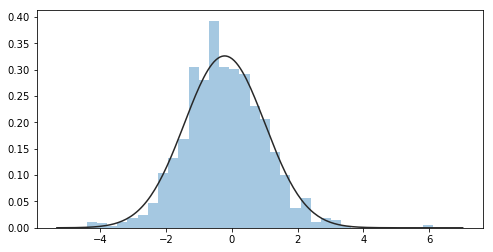

In [2655]:
sns.distplot(model.decision_function(Xr2_test), fit=norm, kde=False)

The residuals are close to normally distributed

In [2656]:
from sklearn.metrics import confusion_matrix
preds = [1 if p == '16-31.9' else 0 for p in model.predict(Xr2_test)]
confusion_matrix(Y_binary, preds)

array([[529, 202],
       [114, 250]])

The model is having the greatest difficulty classifying the samples with low death rates. Class imbalance could be a factor, even though the algorithms are usimg the 'balanced' class weight parameter. Try a different split to see if performance is consistent.

In [2658]:
# Make it easy to experiment with train/test split ratios and random states
features2.remove('urban_inf')
X = data.loc[:, features2]
idx = X.index
X = pd.DataFrame(robust.fit_transform(X), index=idx, columns=features2)
X['urban_inf'] = data['urban_inf']
X = pd.get_dummies(X, prefix='urb_inf_', columns=['urban_inf'])

Y16 = data.loc[:, 'death_rate']
Y16 = Y16.apply(lambda x: '0-1.9' if x == '<2' else x)
Y16 = Y16.apply(lambda x: '30-31.9' if x == '30+' else x)
Y8 = combine_targets(Y16)
Y4 = combine_targets(Y8)
Y = combine_targets(Y4)

In [2659]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.35, random_state=37, stratify=Y)
model = GridSearchCV(lrc, param_grid=params)
model.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'penalty': ['l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2660]:
model.best_estimator_

LogisticRegression(C=4, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [2661]:
matthews_corrcoef(Y_test, model.predict(X_test))

0.41132173920249643

In [2662]:
Y_binary = [1 if p == '16-31.9' else 0 for p in Y_test]
roc_auc_score(Y_binary, model.decision_function(X_test))

0.7723651177823545

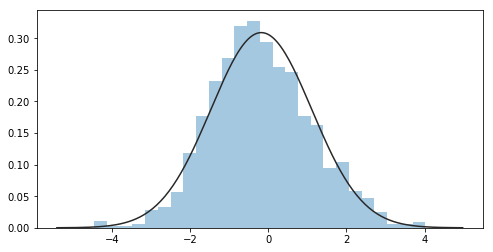

In [2663]:
sns.distplot(model.decision_function(X_test), fit=norm, kde=False)

In [2664]:
preds = [1 if p == '16-31.9' else 0 for p in model.predict(X_test)]
confusion_matrix(Y_binary, preds)

array([[528, 203],
       [106, 258]])

The model is stable with respect to different data splits. Investigate the regression coefficients.

In [2665]:
results = zip(X_test.columns, lrc.coef_[0])
feature_rank = sorted(results, key=lambda tup: tup[1], reverse=True)    
for f, r in feature_rank:
    print('{:13.12}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))

unemployment :  1.26639  OR: 3.55 
crime        :  0.85418  OR: 2.35 
urb_inf__1   :  0.60130  OR: 1.82 
urb_inf__11  :  0.30768  OR: 1.36 
urb_inf__4   :  0.26597  OR: 1.30 
unemp_change :  0.26159  OR: 1.30 
urb_inf__10  :  0.23752  OR: 1.27 
urb_inf__7   :  0.22423  OR: 1.25 
median_age   :  0.22348  OR: 1.25 
urb_inf__12  :  0.18153  OR: 1.20 
urb_inf__2   :  0.15831  OR: 1.17 
vets         :  0.08859  OR: 1.09 
pop_inc      :  0.04510  OR: 1.05 
hh_hisp      :  0.01989  OR: 1.02 
urb_inf__3   :  0.00607  OR: 1.01 
pov_change   : -0.14746  OR: 0.86 
urb_inf__6   : -0.22151  OR: 0.80 
degree+      : -0.22525  OR: 0.80 
urb_inf__9   : -0.26596  OR: 0.77 
urb_inf__8   : -0.30884  OR: 0.73 
hh_afr_am    : -0.79079  OR: 0.45 
urb_inf__5   : -1.01574  OR: 0.36 


There is strong overlap with the results obtained by the analysis using feature selection on the raw data with standard scaling for the modeling. 